This is recent Kaggle Cometition.
Link here: https://www.kaggle.com/c/aptos2019-blindness-detection/overview

You are provided with a large set of retina images taken using fundus photography under a variety of imaging conditions.

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation.

For the purpose of enabling running this over Colab, I have resized the images to 300x300 pixels and provided two numpy files containing all the data. One with images and other with their labels. If you want access to full resulution image you may download from the kaggle page. The total download size is alomost 9 GB.  

**Assignment (3 Marks)**
1. Split the data (3662 images) into a training and test set.
2. Make a CNN to predict the labels for the retinal images.

In [ ]:
#Force google colab to switch to high ram mode. Run it only once. 
a = []
while(1):
    a.append('1')
#Also change runtime type to enable GPU from menu.

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [20]:
##This block is only for access of files using google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import cv2;
import matplotlib.pyplot as plt
import numpy as np;
from random import shuffle;
import cv2;
from random import shuffle;
from tqdm import tqdm;
import tensorflow;
from tensorflow.keras import layers;
from tensorflow.keras import Model;
from tensorflow.keras.optimizers import SGD;
from tensorflow.keras.callbacks import TensorBoard;
IMAGE_SIZE = 300;

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
train_Data_X_File = drive.CreateFile({'id': '1QV0Vq8L4vrHCqigW6kIWKjac3Exd6Och'});
train_Data_Y_File = drive.CreateFile({'id': '1Gdr91plxjjwUAGHLHlT9Im-bVybVp3p7'});

In [24]:
#This block takes 4-5 minutes to load the training data.
train_Data_X_File.GetContentFile('train_Data_X.npy');
train_Data_X = np.load('train_Data_X.npy', allow_pickle=True)

train_Data_Y_File.GetContentFile('train_Data_Y.npy');
train_Data_Y = np.load('train_Data_Y.npy', allow_pickle=True)

In [25]:
train_Data_X.shape
#No of training images, First columns is of images and second is of labels

(3662, 1, 300, 300, 3)

In [26]:
train_Data_Y.shape

(3662, 1)

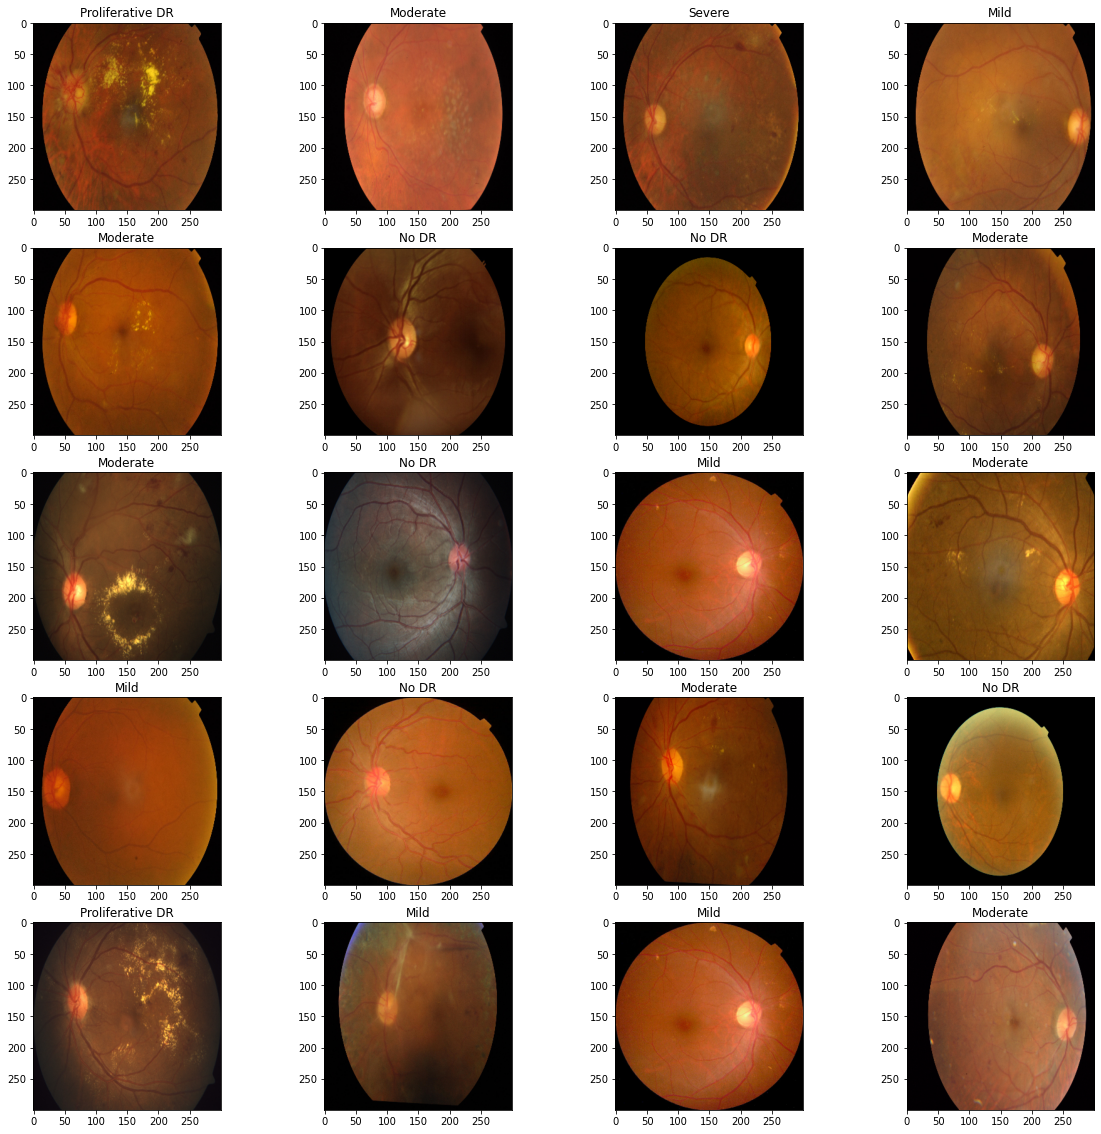

In [27]:
#Show some training images with labels
count = 0;
Num_of_Images = 20;
plt.figure(figsize=(20,20))
label = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'];
for i in np.random.randint(1000, size = Num_of_Images):
  count = count+1;
  plt.subplot(Num_of_Images/4,4, count);
  plt.imshow(np.reshape(train_Data_X[i],(IMAGE_SIZE,IMAGE_SIZE,3)));
  plt.title(label[int(train_Data_Y[i])]);

In [28]:
# Prepare the data for the training and testing in CNN
Y_data = np.zeros([train_Data_X.shape[0],5]);
for i in range(len(Y_data)):
  Y_data[i, train_Data_Y[i]] = 1;
Y_data

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [29]:
# splitting the data (3662 images) into a training and test set (20%).
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_Data_X, Y_data, test_size=0.2, random_state=1)

In [30]:
#reshaping the data 
X_train = X_train.reshape(-1,IMAGE_SIZE, IMAGE_SIZE,3);
X_test = X_test.reshape(-1,IMAGE_SIZE, IMAGE_SIZE,3);

In [31]:
# Our input feature map is 300x300x3: 75x75 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#converting into float values
img_input1 = layers.Lambda(lambda x: x /255)(img_input)

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(img_input1)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu',kernel_initializer='he_normal',padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu',kernel_initializer='he_normal',padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# fourth convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu',kernel_initializer='he_normal',padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# fifth convolution extracts 256 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(256, 3, activation='relu',kernel_initializer='he_normal',padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 500 hidden units
x = layers.Dense(500, activation='relu')(x)

# Create a fully connected layer with ReLU activation and 125 hidden units
x = layers.Dense(125, activation='relu')(x)

# Create a fully connected layer with ReLU activation and 50 hidden units
x = layers.Dense(50, activation='relu')(x)

# Create output layer with 5 nodes and softmax activation
output = layers.Dense(5, activation='softmax')(x)

# Create model:
model = Model(img_input, output)

In [32]:
#Dimentions and complexcity of model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        1849

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [34]:
#fitting the data into model
model.fit(X_train, Y_train, batch_size =64, epochs = 50,verbose=1, validation_data=(X_test, Y_test))

Epoch 1/50
46/46 [==============================] - 4s 65ms/step - loss: 1.2690 - accuracy: 0.5209 - val_loss: 0.9247 - val_accuracy: 0.6698
Epoch 2/50
46/46 [==============================] - 3s 61ms/step - loss: 0.8821 - accuracy: 0.6830 - val_loss: 0.8964 - val_accuracy: 0.6903
Epoch 3/50
46/46 [==============================] - 3s 61ms/step - loss: 0.8423 - accuracy: 0.6977 - val_loss: 0.8195 - val_accuracy: 0.7026
Epoch 4/50
46/46 [==============================] - 3s 60ms/step - loss: 0.7871 - accuracy: 0.7185 - val_loss: 0.8397 - val_accuracy: 0.6876
Epoch 5/50
46/46 [==============================] - 3s 60ms/step - loss: 0.7742 - accuracy: 0.7152 - val_loss: 0.8006 - val_accuracy: 0.7040
Epoch 6/50
46/46 [==============================] - 3s 61ms/step - loss: 0.7640 - accuracy: 0.7188 - val_loss: 0.7861 - val_accuracy: 0.7135
Epoch 7/50
46/46 [==============================] - 3s 61ms/step - loss: 0.7553 - accuracy: 0.7188 - val_loss: 0.7696 - val_accuracy: 0.7094
Epoch 8/50
46

In [35]:
test_loss, test_acc = model.evaluate(X_test,Y_test, verbose=2) #compare how the model performs on the test dataset

print('\nTest accuracy:', test_acc*100)

23/23 - 0s - loss: 0.7954 - accuracy: 0.7285

Test accuracy: 72.85129427909851
